# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science 

# Section 11: Bagging & Random Forests

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import tree

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [3]:
# Supress pesky warnings (probably bad practice)
from warnings import simplefilter

simplefilter(action="ignore")

In [ ]:
import os
import subprocess

# Define the name of the zip file containing your assets
assets_zip_name = "notebook_assets.zip"

# Define the directories that should be present after extraction
expected_dirs = ["data", "fig"]

# Construct the raw GitHub URL for the zip file
github_raw_url = f"https://github.com/Harvard-CS1090A/2025-public/raw/main/sec11/{assets_zip_name}"

# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    print("Running in Google Colab. Checking for necessary files...")

    # Check if the expected directories already exist
    all_dirs_exist = True
    for d in expected_dirs:
        if not os.path.isdir(d):
            all_dirs_exist = False
            break

    if all_dirs_exist:
        print("Required directories already exist. Skipping download.")
    else:
        print(f"Required directories not found. Downloading {assets_zip_name} from GitHub...")

        try:
            # Download the zip file
            subprocess.run(['wget', '-q', github_raw_url], check=True)
            print(f"Downloaded {assets_zip_name}.")

            # Unzip the file
            subprocess.run(['unzip', '-q', assets_zip_name], check=True)
            print(f"Extracted {assets_zip_name}.")

            # Clean up the zip file
            subprocess.run(['rm', assets_zip_name], check=True)
            print(f"Removed {assets_zip_name}.")

            print("All necessary files are now available.")

        except subprocess.CalledProcessError as e:
            print(f"Error during file download or extraction: {e}", file=sys.stderr)
        except FileNotFoundError:
            print("wget or unzip command not found. Please ensure they are installed.", file=sys.stderr)

else:
    print("Not running in Google Colab. Assuming files are locally available.")

## Table of Contents

1. Decision trees recap + quick practice questions  
2. Housing regression with a single tree  
3. Bagging: many deep trees averaged  
4. Random Forest: Bagging + feature subsampling  
5. Final comparison + practical takeaways

## 🌳 Classification Decision Trees Recap



### Classification metrics  

**Gini index ('impurity')**  

For a region $R_r$ created by splitting on predictor $p$ at threshold $t_p$:


$$\text{Gini}(R_r \mid p, t_p) = 1 - \sum_{k=1}^K \Psi(k \mid R_r)^2$$


where $\Psi(k \mid R_r)$ is the proportion of training points in class $k$ that fall inside region $R_r$.

- Lower Gini $\rightarrow$ purer (more homogeneous) node.


**Entropy ('disorder')**  

For a region $R_r$ created by splitting on predictor $p$ at threshold $t_p$:


$$\text{Entropy}(R_r \mid p, t_p) = - \sum_{k=1}^K \Psi(k \mid R_r)\,\log_2 \big(\Psi(k \mid R_r)\big)$$


where $\Psi(k \mid R_r)$ is the proportion of training points in class $k$ that fall inside region $R_r$.

- Lower Entropy $\rightarrow$  purer (more homogeneous) node.

---

### Choosing a split (continuous features)
- For a feature, try different thresholds **between unique values**.  
- For each threshold, compute **weighted impurity** of left/right children.  
- Pick the split with the **largest impurity decrease** (equivalently, lowest weighted impurity).


**Purity, greedy splitting, and depth**  
- Each split tries to make child nodes **more homogeneous** than the parent.  
- Algorithm is **greedy**: it chooses the best split *at that node only* (no global lookahead).  
- Deeper levels usually have **higher purity**, but risk overfitting.


**Bias-variance for trees**  
- **Shallow tree:** high bias, low variance (underfits).  
- **Deep / fully grown tree:** low bias, high variance (overfits).  
- Very deep trees can fit training data almost perfectly but are **unstable** (small data changes $\rightarrow$ very different tree).

### Decision Tree Hyperparameters

**1. Single decision trees - control complexity (bias/variance)**  
These hyperparameters decide *how big / complex* each tree is:

- `max_depth`: maximum depth of the tree.
- `min_samples_leaf`, `min_samples_split`: how many samples we require before splitting / making a leaf.

These are **stopping conditions**. Deeper trees $\rightarrow$ lower bias, higher variance.  
Shallower trees $\rightarrow$ higher bias, lower variance.

## ❓ Decision Tree Review Questions

As a quick exercise, break out into groups of 3 and attempt the following questions! We'll go over it together afterwards!

### Q1. Choosing a Split (Continuous Feature)

**Question:**
At a node with 100 training points, you consider a continuous feature $X$. How does CART (the decision tree implementation described in class) choose the split on (X)?

A. Try only the median of $X$; choose it if it reduces training error  
B. Try thresholds between sorted unique values of X; for each, compute the weighted impurity of the two child nodes and choose the split with the lowest weighted impurity  
C. Try all integer thresholds from $\min(X)$ to $\max(X)$; choose the one with the lowest impurity of the left child  
D. Randomly choose one threshold; if impurity decreases, keep it  

### Q2. Comparing Node Purity (Gini)

**Question:**
Which node is **most pure** according to the Gini index?

* Node A: 50 points, 25 from class 1, 25 from class 2
* Node B: 50 points, 40 from class 1, 10 from class 2
* Node C: 50 points, 50 from class 1, 0 from class 2

A. Node A  
B. Node B  
C. Node C  
D. Nodes B and C tie  

### Q3. Effect of Pruning

**Question:**
You fit a very deep tree that overfits. You then prune it (limit depth or remove weak branches). What is the typical effect?

A. Decreases both bias and variance  
B. Increases bias and decreases variance  
C. Decreases bias and increases variance  
D. Leaves bias and variance roughly unchanged  

---

## 🏘️ Regression Example: Cambridge Housing Prices Example

### The Dataset

In [4]:
homes = pd.read_csv("data/cambridgehomes.csv")
homes_raw = homes

In [6]:
# Bare minimum preprocessing
homes["zip"] = homes["zip"].astype(str)
homes["lotsize"] = homes["lotsize"].fillna(0)
homes["hoa"] = homes["hoa"].fillna(0)

type_dummies = pd.get_dummies(homes["type"], drop_first=True)
homes = pd.concat([homes, type_dummies], axis=1)

homes.dtypes

date             object
type             object
address          object
city             object
zip              object
price             int64
beds              int64
baths           float64
neighborhood     object
sqft              int64
lotsize         float64
year              int64
hoa             float64
url              object
mls               int64
latitude        float64
longitude       float64
dist            float64
multifamily        bool
singlefamily       bool
townhouse          bool
multifamily        bool
singlefamily       bool
townhouse          bool
dtype: object

In [7]:
y = np.log2(homes["price"] / 1000)

X = homes[
    [
        "multifamily",
        "singlefamily",
        "townhouse",
        "sqft",
        "dist",
        "beds",
        "baths",
        "year",
        "hoa",
        "lotsize",
    ]
]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=109
)

In [8]:
X_train.head()

,multifamily,multifamily,singlefamily,singlefamily,townhouse,townhouse,sqft,dist,beds,baths,year,hoa,lotsize
503,False,False,False,False,False,False,663,3.912715,1,1.0,1998,759.0,0.0
53,False,False,False,False,False,False,2638,2.665479,4,3.5,1880,100.0,0.0
247,False,False,False,False,False,False,1035,1.417904,2,1.0,1903,225.0,0.0
219,False,False,False,False,True,True,2487,3.433153,4,4.5,1900,200.0,0.0
310,False,False,True,True,False,False,3974,1.765512,4,4.5,1913,0.0,4685.0


We predict $\log_2(\text{price}/1000)$ instead of raw price to make the distribution less skewed.

### Quick EDA

Distribution of the target variable (log price)

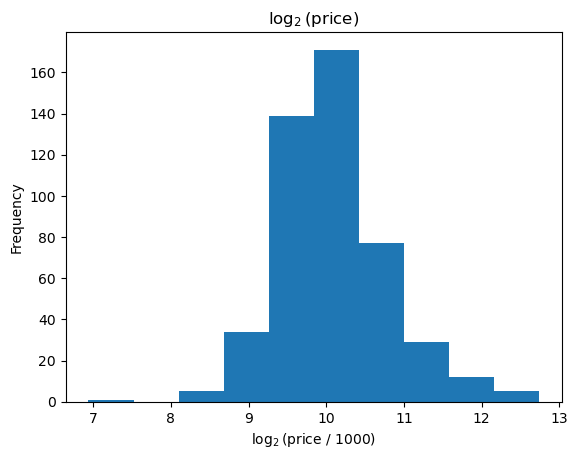

In [9]:
y_train.plot(kind="hist", title=r"$\log_2$(price)")
plt.xlabel(r"$\log_2$(price / 1000)");

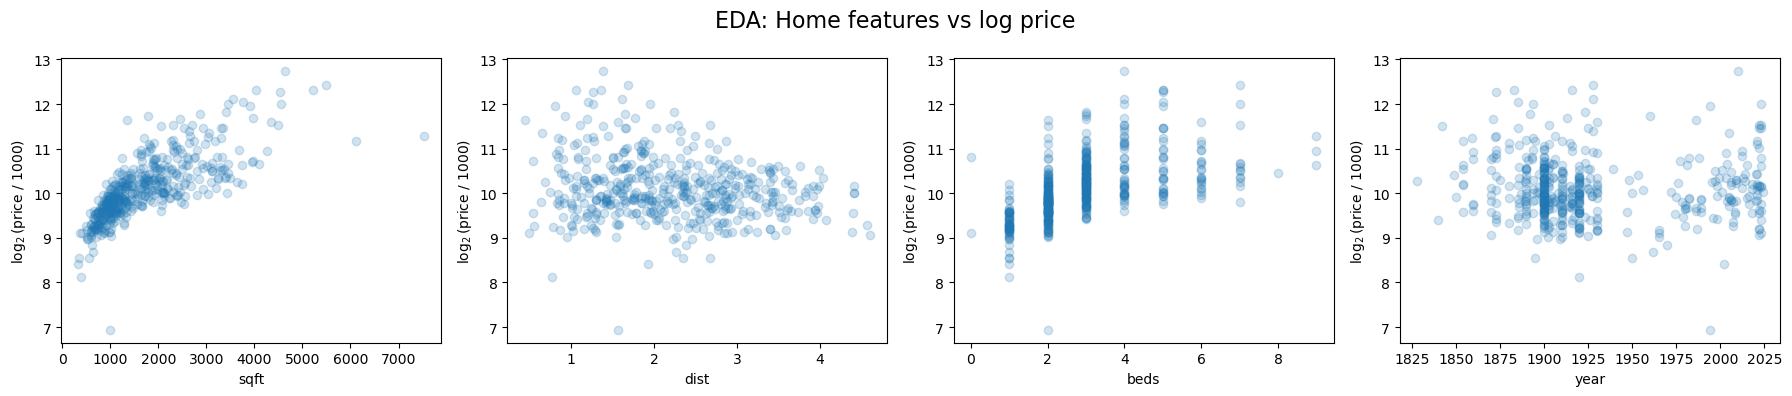

In [10]:
features_to_plot = ["sqft", "dist", "beds", "year"]

nrow = 1
ncol = len(features_to_plot)
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18, 4))

fig.suptitle("EDA: Home features vs log price", fontsize=16)

for ax, column in zip(axs.reshape(-1), features_to_plot):
    ax.scatter(X_train[column], y_train, alpha=0.2)
    ax.set_xlabel(column)
    ax.set_ylabel(r"$\log_2$(price / 1000)")

plt.tight_layout()

We see:

- **sqft** and **beds**: positive relationship with log price.  
- **dist** (distance from center): tends to have a negative relationship.  
- Some predictors are stronger than others.

Next, we'll fit a **decision tree regressor** and see how tree hyperparameters
(`max_depth`, `min_samples_leaf`, etc.) affect performance on this dataset.


### Decision Tree Regression + Hyperparameters

In [15]:
# Basic Tree Fit

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
rmse_tree

0.3920774913625021

In [16]:
# Effect of max_depth

depths = [2, 4, 6, 8, None]
results = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results.append((d, rmse))

results

[(2, 0.4467466776867115),
 (4, 0.36372264014575667),
 (6, 0.32262243357767395),
 (8, 0.354604988982734),
 (None, 0.3920774913625021)]

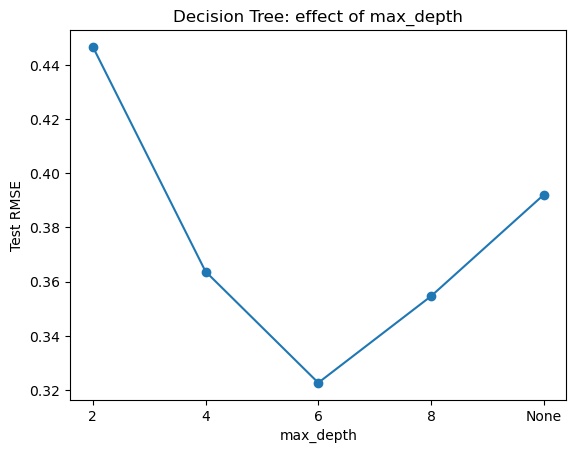

In [17]:
depth_vals = [str(d) for d, _ in results]
rmse_vals = [rmse for _, rmse in results]

plt.plot(depth_vals, rmse_vals, marker="o")
plt.xlabel("max_depth")
plt.ylabel("Test RMSE")
plt.title("Decision Tree: effect of max_depth");

### Interpreting the effect of `max_depth`

From the plot/numbers, we see:

- `max_depth = 2` $\rightarrow$ highest RMSE: the tree is **too simple** $\rightarrow$ underfits (**high bias**).
- Increasing depth to 4 and 6 **improves** test RMSE: the tree can capture more structure.
- Around `max_depth = 6` we get the **best** test RMSE (sweet spot for this dataset).
- Going deeper (8 or `None` = fully grown) makes test RMSE **worse again** $\rightarrow$ the tree starts to **overfit** (**high variance**).

This is the classic **bias–variance tradeoff** for decision trees:

- Shallow trees $\rightarrow$ high bias, low variance.  
- Very deep trees $\rightarrow$ low bias, high variance.  
- A moderate depth often gives the best generalization performance.

### From a single tree to an ensemble

We just saw that:

- Very **shallow** trees underfit (high bias).
- Very **deep** trees overfit (high variance).
- A medium `max_depth` can work well, but a single tree is still **unstable**:
  small changes in the training data can lead to a very different tree.

Another way to reduce **variance** is to keep using **high-variance trees**
(e.g., deep trees) but **average many of them**.

This idea is called **Bagging** (**B**ootstrap **Agg**regat**ing**).

### What Bagging does

1. **Bootstrap samples**  
   - From the original training set, draw $B$ new datasets of the **same size**,  
     each sampled **with replacement** (so some points repeat, some are left out).

2. **Fit one high-variance model per bootstrap sample**  
   - Here, we fit a **deep decision tree** on each bootstrap sample  
     $\rightarrow$ $\text{Tree}_1, \text{Tree}_2, \dots, \text{Tree}_B$.

3. **Aggregate their predictions**  
   - **Regression:** average the $B$ predictions.  
   - **Classification:** take a majority vote.

Because each tree sees a slightly different dataset, their errors are **less correlated**.  
Averaging them keeps the **low bias** of deep trees but **reduces variance**, giving more
stable, better generalizing predictions.


<img src="fig/bagging1.png" alt="bagging" width="60%"/>

### Bagging Implementation

In [18]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# High-variance base learner: deep tree
base_tree = DecisionTreeRegressor(
    max_depth=None,
    min_samples_leaf=1,
    random_state=109
)

bag = BaggingRegressor(
    estimator=base_tree,
    n_estimators=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=109
)

bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)

mse_bag = mean_squared_error(y_test, y_pred_bag)
rmse_bag = np.sqrt(mse_bag)
rmse_bag


0.30847264163582205

#### How n_estimators behaves:

This helps us see that adding more trees $\neq$ overfitting

In [19]:
n_list = [1, 10, 50, 100, 200]
bag_results = []

for n in n_list:
    bag = BaggingRegressor(
        estimator=base_tree,
        n_estimators=n,
        bootstrap=True,
        n_jobs=-1,
        random_state=109
    )
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    bag_results.append((n, rmse))

bag_results

[(1, 0.4040785335631112),
 (10, 0.3280338007374429),
 (50, 0.308778939967646),
 (100, 0.30847264163582205),
 (200, 0.3109338161748684)]

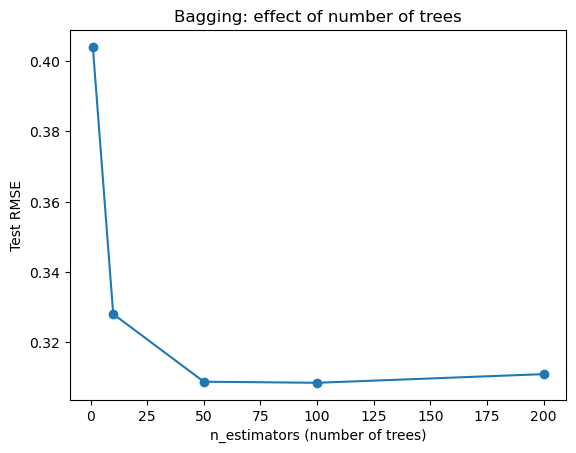

In [20]:
n_vals = [n for n, _ in bag_results]
rmse_vals = [rmse for _, rmse in bag_results]

plt.plot(n_vals, rmse_vals, marker="o")
plt.xlabel("n_estimators (number of trees)")
plt.ylabel("Test RMSE")
plt.title("Bagging: effect of number of trees");


#### Bagging hyperparameters (what changed vs a single tree?)

With Bagging we have:

- **Tree-level hyperparameters** (same as before):  
  `max_depth`, `min_samples_leaf`, `min_samples_split`  
  $\rightarrow$ control how **complex** each tree is (bias/variance of the base learner).

- **New ensemble hyperparameter**:  
  `n_estimators` = number of trees we average  
   $\rightarrow$ controls **variance** of the ensemble.

Key idea:

- A single deep tree is **low bias, high variance**.
- Bagging keeps the trees deep (low bias) but **averages many of them**, so
  variance drops.
- Increasing `n_estimators` does **not** cause overfitting; test error usually
  improves then **plateaus** as we add more trees.

### From Bagging to Random Forest

Bagging already:

- Trains many **bootstrapped trees**.
- Averages their predictions to **reduce variance**.

**Random Forest** adds one more source of randomness:

- At each split, a tree only looks at a **random subset of features** instead of all features.

This:
- Forces different trees to consider **different predictors**,
- Makes trees **less correlated** with each other,
- So averaging them can reduce variance **even more** than plain Bagging.


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=100,     # number of trees
    max_depth=None,       # let trees grow deep
    min_samples_leaf=1,
    max_features="sqrt",  # random subset of features at each split
    n_jobs=-1,
    random_state=109
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
rmse_rf

0.30853732865271705

#### Random Forest hyperparameters

Random Forest keeps all the **tree-level** and **ensemble-level** hyperparameters
we've already seen, plus one key new one.

- **Tree complexity (same as single tree / Bagging):**
  - `max_depth`, `min_samples_leaf`, `min_samples_split`
  - $\rightarrow$ control how **complex** each tree can be (bias/variance of base learner).

- **Ensemble size (same as Bagging):**
  - `n_estimators` = number of trees we average
  - $\rightarrow$ controls **variance** via averaging; more trees $\rightarrow$ more stable, until it plateaus.

- **New in Random Forest: feature subsampling**
  - `max_features` = how many predictors to consider at each split.
  - Smaller `max_features`:
    - trees see **different subsets** of features,
    - trees become **less correlated**,
    - averaging them gives better **variance reduction**.
  - `max_features` is **not** a stopping rule; it doesn't limit depth, just which
    features are allowed to compete at each split.

In short:

- Tree hyperparameters $\rightarrow$ control **complexity**.
- `n_estimators` $\rightarrow$ controls **variance** by averaging more trees.
- `max_features` $\rightarrow$ controls **correlation** between trees in a Random Forest.


## QUICK RECAP

### Final Comparison: Single Tree vs Bagging vs Random Forest

Let's summarize what we observed on the Cambridge housing data:

| Model                          | Bias            | Variance         | Key Hyperparameters                       | Typical Behavior                       | Test RMSE (ours) |
|--------------------------------|-----------------|------------------|--------------------------------------------|----------------------------------------|------------------|
| **Single Decision Tree**       | Low-Medium bias | **High variance** | `max_depth`, `min_samples_leaf`            | Unstable; small data changes $\rightarrow$ new tree | ~0.3228 |
| **Bagging (Trees)**            | **Low bias**    | Medium variance  | `n_estimators`                              | Averages many deep trees $\rightarrow$ variance drops | ~0.3084 |
| **Random Forest**              | Low-Medium bias | Low-Medium variance | `n_estimators`, `max_features`             | Further de-correlates trees $\rightarrow$ usually best generalization | ~0.3085 |

**Key takeaways**:

- A **single deep tree** overfits and is unstable (high variance).  
- **Bagging** keeps trees deep (low bias) but **averages them** to reduce variance.  
- **Random Forest** = Bagging + **feature subsampling** (`max_features`)  
  $\rightarrow$ reduces **correlation** between trees $\rightarrow$ often slightly better than Bagging.  
- In practice, **Random Forest and Bagging often perform similarly**, especially on small/medium datasets or when a few strong predictors dominate.


**A note on Random Forest vs Bagging**

In our results, **Random Forest and Bagging have almost identical test RMSE**.  
That's not a bug - it's an important point:

- Random Forest does **not** guarantee strictly better performance than Bagging on every dataset.
- Its extra randomness (`max_features`) can:
  - **Help** when features are correlated or when we really want to decorrelate trees.
  - **Hurt slightly** when a few features are very strong and we sometimes *hide* them from splits.
- With a reasonable choice of hyperparameters, Bagging and Random Forest often end up in the **same ballpark** in terms of test error.

So the way to think about it:

- Use **Bagging** when you just want to average many strong base trees.  
- Use **Random Forest** when you also want to **decorrelate** trees via feature subsampling - often helpful, but not magically better every time.


# APPENDIX

### Out-of-Bag Score (OOB)

Out-of-Bag (OOB) Error

In Bagging and Random Forests, each tree is trained on a **bootstrap sample**:
- About **63%** of the training data appears in the bootstrap sample.
- The remaining **37%** are **out-of-bag (OOB)** for that tree (not used to train it).

We can use those OOB points as a **built-in validation set**:

- For each training point, collect predictions from all trees where it was OOB.
- Average those predictions $\rightarrow$ **OOB prediction**.
- Compare to the true value $\rightarrow$ **OOB error estimate**.

**Why OOB is useful**
- Gives a **free cross-validation-like estimate** without an extra validation set.
- Especially helpful when data is limited.
- In `sklearn`, we get it by setting `oob_score=True` (with `bootstrap=True`).

<img src="fig/oob.png" alt="tree_adj" width="60%"/>

Below is a quick Random Forest example with an OOB score.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf_oob = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    bootstrap=True,
    oob_score=True,   # turn on OOB
    n_jobs=-1,
    random_state=109,
)

rf_oob.fit(X_train, y_train)

print(f"Train R^2: {rf_oob.score(X_train, y_train):.4f}")
print(f"Test  R^2: {rf_oob.score(X_test, y_test):.4f}")
print(f"OOB   R^2: {rf_oob.oob_score_:.4f}")


Train R^2: 0.9711
Test  R^2: 0.8087
OOB   R^2: 0.7896


### Visualization: How `n_estimators` affects Random Forest performance

We can repeat the same idea as Bagging and see how the **train**, **OOB**, and **test**
scores evolve as we increase the number of trees in a Random Forest.

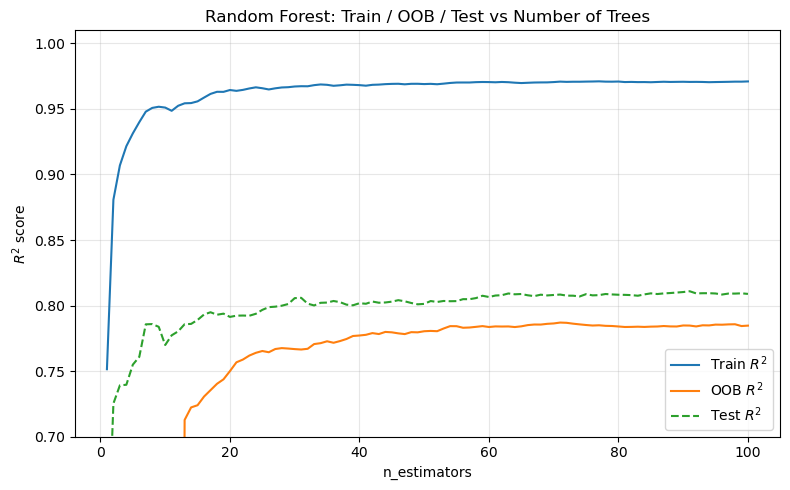

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

max_estimators = 100
train_scores_rf = np.zeros(max_estimators)
oob_scores_rf = np.zeros(max_estimators)
test_scores_rf = np.zeros(max_estimators)

for i, n in enumerate(range(1, max_estimators + 1)):
    rf_tmp = RandomForestRegressor(
        n_estimators=n,
        max_features="sqrt",
        max_depth=None,
        bootstrap=True,
        oob_score=True,   # NOTE: parameter is oob_score, not oob_score_
        n_jobs=-1,
        random_state=109,
    )
    rf_tmp.fit(X_train, y_train)

    train_scores_rf[i] = rf_tmp.score(X_train, y_train)          # train R^2
    oob_scores_rf[i] = rf_tmp.oob_score_                         # OOB R^2
    test_scores_rf[i]  = rf_tmp.score(X_test, y_test)            # test R^2

plt.figure(figsize=(8, 5))
xs = range(1, max_estimators + 1)
plt.plot(xs, train_scores_rf, label="Train $R^2$")
plt.plot(xs, oob_scores_rf,   label="OOB $R^2$")
plt.plot(xs, test_scores_rf,  label="Test $R^2$", linestyle="--")

plt.title("Random Forest: Train / OOB / Test vs Number of Trees")
plt.xlabel("n_estimators")
plt.ylabel("$R^2$ score")
plt.ylim(0.7, 1.01)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### SKLearn's BaggingRegressor

From SKlearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html):


"A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it."

Key arguments:

- `estimator`: the **base estimator** to be bagged (e.g., `DecisionTreeRegressor`).
- `n_estimators`: the **number of base estimators** in the ensemble.
- `oob_score`: set to `True` if you want to compute the **out-of-bag score** 
  (`oob_score_` attribute) using OOB samples.
- `estimators_`: after fitting, this holds the list of fitted base estimators.
- `warm_start=True`: allows re-using previously fitted estimators when increasing 
  `n_estimators`, so you only fit the *new* trees (saves computation).

Below, we use these ideas in a small activity to see how **train** and **OOB** performance
change as we add more trees.

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ ACTIVITY:</strong> Effect of Number of Estimators on BaggingRegressor
</div>  

- Create a visualization showing how the number of estimators affects the BaggingRegressor's **train** and **OOB** scores.
- Use default, **full-depth trees** as your base estimators.
- There are many ways to accomplish this!

**Hint:** You may want to adjust the y-axis limits of your plot.  
Why is this necessary? (Think about how close scores get to 1 for overfit models.)

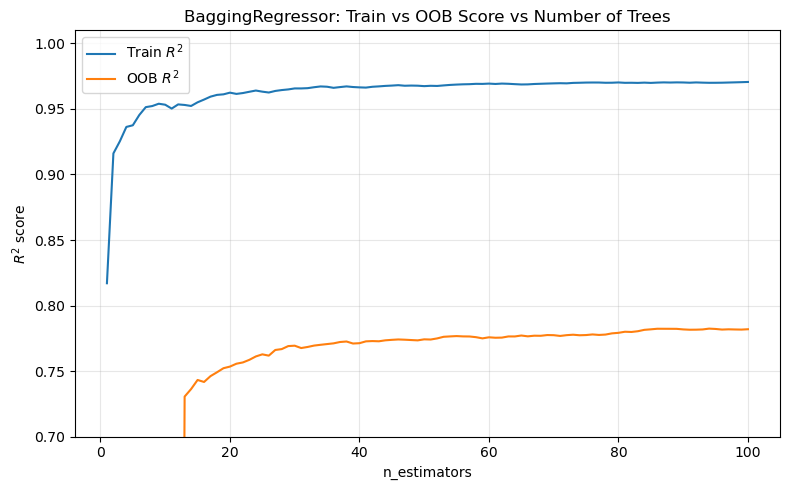

In [23]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

# Base estimator: deep tree (high-variance learner)
base_tree = DecisionTreeRegressor(
    max_depth=None,
    random_state=109
)

bag = BaggingRegressor(
    estimator=base_tree,
    n_estimators=1,      # we will change this in the loop
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=109
)

max_estimators = 100
train_scores = np.zeros(max_estimators)
oob_scores = np.zeros(max_estimators)

for i, n in enumerate(range(1, max_estimators + 1)):
    bag.n_estimators = n
    bag.fit(X_train, y_train)
    train_scores[i] = bag.score(X_train, y_train)  # R^2 on train
    oob_scores[i] = bag.oob_score_                 # R^2 on OOB samples

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_estimators + 1), train_scores, label="Train $R^2$")
plt.plot(range(1, max_estimators + 1), oob_scores, label="OOB $R^2$")
plt.title("BaggingRegressor: Train vs OOB Score vs Number of Trees")
plt.xlabel("n_estimators")
plt.ylabel("$R^2$ score")
plt.ylim(0.7, 1.01)  # adjust as needed based on your data
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

We see:

- **Train $R^2$** starts very high (especially as the number of trees grows, since each tree can overfit its own bootstrap sample).
- **OOB $R^2$** starts lower but usually **increases and then plateaus** as `n_estimators` grows.
- OOB gives a **realistic estimate of test performance** without needing a separate validation set.

As with our earlier discussion:

- `n_estimators` mainly controls **variance** (more trees $\rightarrow$  more averaging $\rightarrow$ more stable).
- Increasing `n_estimators` does **not** cause overfitting; performance just stabilizes.

---

## Why Are Bagged Trees Still Correlated?

Each tree is trained on a different bootstrap sample, but:

- Trees are **greedy**: at each split, they pick the feature with the **largest impurity reduction**.
- If a few predictors are very strong, every tree will choose them first.
- This causes **correlation between trees**, even when bootstrap sampling differs.
- Highly correlated trees limit Bagging's ability to reduce variance.

This motivates Random Forest's additional randomness.

## Why Random Forest Improves Over Bagging

Random Forest = Bagging + random feature subsampling.

At each split, instead of using **all J predictors**, a tree uses only **J' predictors**  
(e.g., `max_features="sqrt"`).

This:
- Forces trees to consider different predictors.
- Makes trees **less correlated**.
- Allows averaging to reduce **more variance**.

RF does **not** guarantee improvement on every dataset  
(e.g., when a few predictors dominate),  
but often improves generalization.

---

## Tuning RF

## Tuning a Random Forest

The main hyperparameters to tune:

1. **`max_features`**  
   Controls correlation between trees.  
   Lower $\rightarrow$ more decorrelated $\rightarrow$ reduced variance.

2. **`min_samples_split`** or **`min_samples_leaf`**  
   Controls tree complexity (overfitting vs smoothing).

Optional:
- **`n_estimators`** (usually just set large enough: 200-500+)
- **`max_depth`** (if trees are overfitting)

## GridSearchCV Example

GridSearchCV performs an exhaustive search over a specified range of hyperparameter values to find the combination that yields the best model performance.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "min_samples_split": [2, 5, 10, 20],
    "max_features": [2, 5, 8],
}

rf_cv = GridSearchCV(
    estimator=RandomForestRegressor(random_state=109, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
)

rf_cv.fit(X_train, y_train)

print("Best parameters:", rf_cv.best_params_)
print("Best CV score:", rf_cv.best_score_)


Best parameters: {'max_features': 8, 'min_samples_split': 2}
Best CV score: 0.7832023988759966


In [26]:
rf_tuned = RandomForestRegressor(
    max_features=rf_cv.best_params_["max_features"],
    min_samples_split=rf_cv.best_params_["min_samples_split"],
    random_state=109,
    n_jobs=-1,
).fit(X_train, y_train)

## Interpreting Tree-Based Models

Two common approaches:

### 1. Mean Decrease in Impurity (MDI)
- Default `feature_importances_` from trees / RF.
- Measures how much each feature reduces impurity across all splits.
- Fast, but biased when predictors are correlated.

### 2. Permutation Importance
- Randomly shuffle one feature in the validation data.
- Measure how much model performance drops.
- More reliable, works with correlated features.
- Slower (requires many re-evaluations).

---

## Model Interpretability

As a data scientist, you must understand not only **how well** a model performs but **why** it produces the predictions it does. Stakeholders often require interpretations that are:

- Trustworthy  
- Transparent  
- Accountable  

Tree-based models (Decision Trees, Bagging, Random Forests) can be accurate, but interpreting them requires additional tools.

There is a natural **trade-off between interpretability and accuracy**:

- **Interpretable models**  
  - Linear regression, logistic regression, shallow trees  
  - Easy to explain, but often too simple  
- **Model-specific explanations**  
  - e.g., "feature importance" from trees  
  - Not generalizable across model classes  
- **Model-agnostic methods (recommended)**  
  - Partial Dependence Plots (PDP)  
  - ICE curves  
  - SHAP  
  - These work for *any* ML model

One of the simplest interpretability tools is:

**Plot the model's predictions by varying one feature at a time** while holding all other features constant.

This mimics what we did for k-NN and allows us to see the "functional shape" between a predictor and the response.


**Fitting simple models using only sqft**

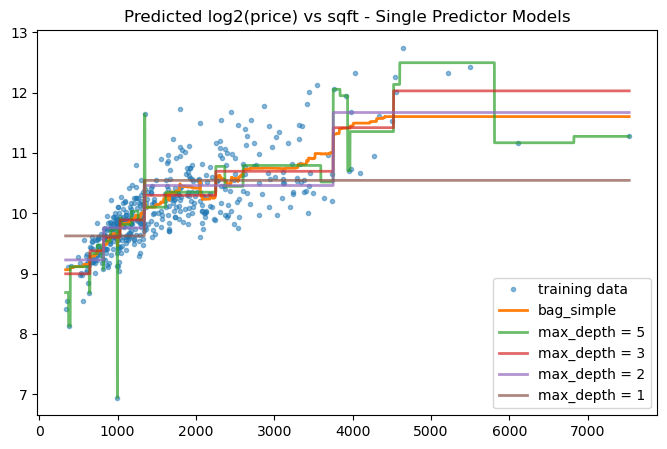

In [31]:
# Generate range of sqft values
dummy_x = np.arange(np.min(homes["sqft"]), np.max(homes["sqft"]), 1)

plt.figure(figsize=(8, 5))
plt.plot(X_train["sqft"], y_train, ".", alpha=0.5, label="training data")

# A simple bagging/RF-style model on a single predictor
bag_simple = RandomForestRegressor(
    min_samples_split=50,
    n_estimators=500,
    max_features=1,    # forces splits on sqft only
    oob_score=True,
    random_state=109,
)
bag_simple.fit(X_train[["sqft"]], y_train)

plt.plot(
    dummy_x,
    bag_simple.predict(dummy_x.reshape(-1, 1)),
    label="bag_simple",
    lw=2,
)

# Add shallow -> deep trees
for depth in [5, 3, 2, 1]:
    dtree = DecisionTreeRegressor(max_depth=depth)
    dtree.fit(X_train[["sqft"]], y_train)
    plt.plot(
        dummy_x,
        dtree.predict(dummy_x.reshape(-1, 1)),
        label=f"max_depth = {depth}",
        lw=2,
        alpha=0.7,
    )

plt.title("Predicted log2(price) vs sqft - Single Predictor Models")
plt.legend()
plt.show()

**Questions to reflect on:**

- Which models look **overfit**?  
- Which look **underfit**?  
- What shape does the model learn between `sqft` and log-price?  
- Why is there technically *no* "Random Forest" in the single-predictor case?

**Multiple-predictor trees and ensembles**

In [ ]:
# Well-tuned tree (assuming best_params defined via earlier GridSearch)
dt3 = DecisionTreeRegressor(max_depth=3, random_state=109)
dt3.fit(X_train, y_train)

# "Tuned" tree: a moderately complex tree (hand-picked hyperparameter)
dt_tuned = DecisionTreeRegressor(max_leaf_nodes=40, random_state=109)
dt_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_leaf_nodes=40, random_state=109)

Now we fix ALL predictors at their mean values and vary only `sqft`.  
This isolates the marginal relationship learned by each model.

**Plotting RF predictions vs sqft (holding other predictors constant)**

In [37]:
from sklearn.ensemble import RandomForestRegressor

# "Tuned-ish" Random Forest for interpretation
rf2 = RandomForestRegressor(
    n_estimators=300,
    max_features="sqrt",   # consider sqrt(J) features at each split
    min_samples_split=5,   # a bit of regularization
    random_state=109,
    n_jobs=-1,
)
rf2.fit(X_train, y_train)

print(f"Train R^2: {rf2.score(X_train, y_train):.4f}")
print(f"Test  R^2: {rf2.score(X_test, y_test):.4f}")

Train R^2: 0.9386
Test  R^2: 0.8083


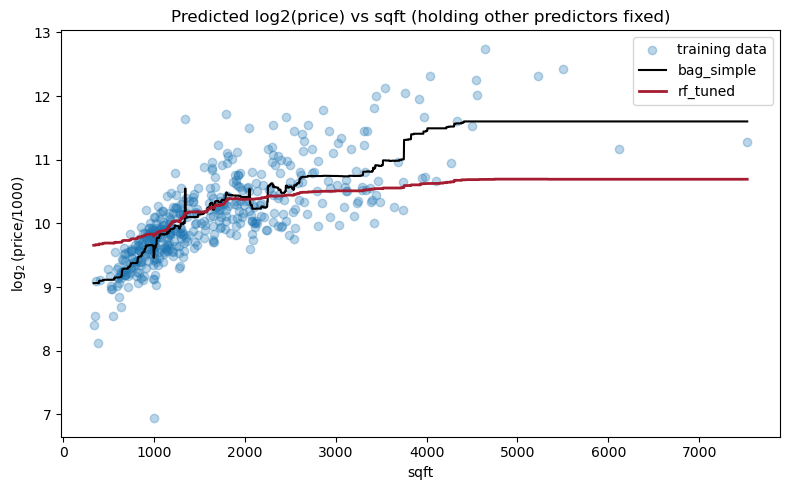

In [38]:
# Build a dataframe where all predictors = their mean, except sqft which varies
means = X_train.mean(axis=0)  # Series of column means

# Create a DataFrame with len(dummy_x) rows, each row = means
means_df = pd.DataFrame(
    np.repeat(means.values.reshape(1, -1), len(dummy_x), axis=0),
    columns=X_train.columns,
)

# Now overwrite sqft with the dummy grid
means_df["sqft"] = dummy_x

# RF predictions using your tuned RF model (rf2 or rf_tuned)
yhat_rf = rf2.predict(means_df)

plt.figure(figsize=(8, 5))
plt.scatter(X_train["sqft"], y_train, label="training data", alpha=0.3)
plt.plot(
    dummy_x,
    bag_simple.predict(dummy_x.reshape(-1, 1)),
    label="bag_simple",
    color="black",
)
plt.plot(dummy_x, yhat_rf, label="rf_tuned", color="#A51C30", lw=2)

plt.title("Predicted log2(price) vs sqft (holding other predictors fixed)")
plt.xlabel("sqft")
plt.ylabel(r"$\log_2(\text{price} / 1000)$")
plt.legend()
plt.tight_layout()
plt.show()

**Questions:**

- How does the RF's relationship between `sqft` and price differ from the simple models above?  
- Why does this happen? (Think: multiple regression vs simple regression, interaction effects, etc.)  

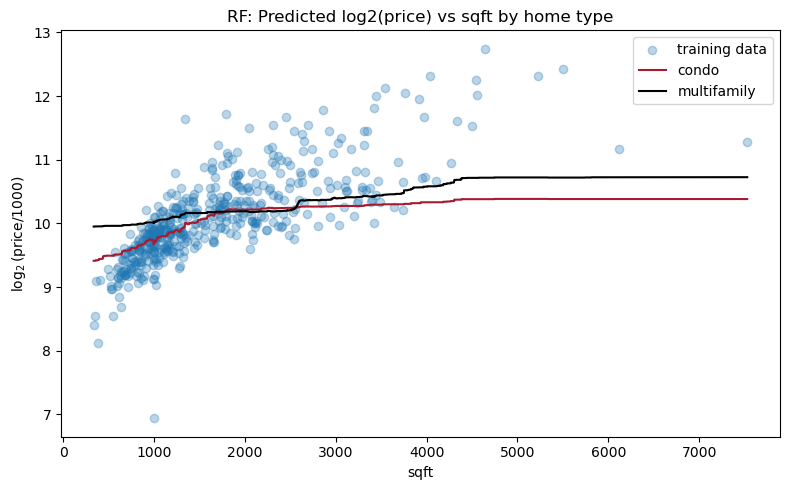

In [41]:
# Prediction curves by home type

# 1) Condos: rows where all three dummy home types are 0
cond_mask = (
    (X_train["multifamily"].values == 0)
    & (X_train["singlefamily"].values == 0)
    & (X_train["townhouse"].values == 0)
)

means_condo = X_train.iloc[cond_mask].mean(axis=0)

condo_df = pd.DataFrame(
    np.repeat(means_condo.values.reshape(1, -1), len(dummy_x), axis=0),
    columns=X_train.columns,
)
condo_df["sqft"] = dummy_x

# 2) Multifamily homes: multifamily == 1
multi_mask = (X_train["multifamily"].values == 1)
means_multi = X_train.iloc[multi_mask].mean(axis=0)

multi_df = pd.DataFrame(
    np.repeat(means_multi.values.reshape(1, -1), len(dummy_x), axis=0),
    columns=X_train.columns,
)
multi_df["sqft"] = dummy_x

# RF predictions
yhat_rf_condo = rf2.predict(condo_df)
yhat_rf_multi = rf2.predict(multi_df)

plt.figure(figsize=(8, 5))
plt.scatter(X_train["sqft"], y_train, alpha=0.3, label="training data")
plt.plot(dummy_x, yhat_rf_condo, label="condo", color="#A51C30")
plt.plot(dummy_x, yhat_rf_multi, label="multifamily", color="black")

plt.title("RF: Predicted log2(price) vs sqft by home type")
plt.xlabel("sqft")
plt.ylabel(r"$\log_2(\text{price} / 1000)$")
plt.legend()
plt.tight_layout()
plt.show()


**Questions:**

- What do you notice about the curves for different home types?  
- What does this say about **interaction effects** between home type and sqft?  

🌈 **The End**